In [1]:
from __future__ import division
from sudoku import Sudoku
import pandas as pd
import subprocess
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
%matplotlib inline

In [3]:
# Global Constants
MIN_VARS = 1
MAX_VARS = 25
INSTANCES_PER_VAR = 100
NUM_VARS = MAX_VARS-MIN_VARS+1
SUDOKU_DEGREE = 9
VAR_COUNT = int(str(SUDOKU_DEGREE) + str(SUDOKU_DEGREE) + str(SUDOKU_DEGREE))

In [4]:
#get main cnf file
path = 'sudoku9.cnf'
cnf = ""

with open(path) as f:
    for line in f:
        cnf+=line

In [5]:
frames = []
for var in range(MIN_VARS, MAX_VARS):
    boards = []
    frame = pd.DataFrame(columns=['board', 'solution'])
    for y in range(INSTANCES_PER_VAR):
        board = Sudoku(SUDOKU_DEGREE)
        board.randomize_board(var)
        boards.append(board)
    cnfs = [board.cnf_output() for board in boards]
    frame['board'] = boards
    frame['cnf'] = cnfs
    frame['k'] = var
    frame['n'] = SUDOKU_DEGREE
    frames.append(frame)
frames = pd.DataFrame(pd.concat(frames))
frames.head(5)

,board,solution,cnf,k,n
0,<sudoku.Sudoku object at 0x7f735be705c0>,NaN,473 0\n,1,9
1,<sudoku.Sudoku object at 0x7f7335801dd8>,NaN,177 0\n,1,9
2,<sudoku.Sudoku object at 0x7f7335801e48>,NaN,119 0\n,1,9
3,<sudoku.Sudoku object at 0x7f7335801e80>,NaN,448 0\n,1,9
4,<sudoku.Sudoku object at 0x7f7335801eb8>,NaN,034 0\n,1,9


In [6]:
def get_solution_from_cnf(cnf_string):
    
    cnf_string = cnf + cnf_string #append the whole cnf
    
    bashCommand = 'minisat %s %s' # command to run on the terminal
    
     # Our temporary input/output files 
    input_file = tempfile.NamedTemporaryFile(mode="w")
    output_file = tempfile.NamedTemporaryFile()
    
    # Count number of clauses
    clause_count = len(cnf_string.splitlines())
    
    # writes the file with DIMACS suitable header
    input_file.write("p cnf " + str(VAR_COUNT) + " " + str(clause_count) + "\n" + cnf_string)
 
    # call the bash terminal
    subprocess.call(bashCommand % (input_file.name, output_file.name), shell=True, stdout = subprocess.PIPE)
    
    input_file.close()
    
    return output_file.read().decode("utf-8") 

In [8]:
%%time
frames['solution'] = frames['cnf'].apply(get_solution_from_cnf)

CPU times: user 3.02 s, sys: 5.4 s, total: 8.42 s
Wall time: 27.2 s


In [10]:
# Dropping unneeded columns and getting the required values

frames2 = frames.drop(columns=['board','cnf','n'])
frames2 = frames2.loc[frames2['solution'] == 'UNSAT\n']
frames2 = frames2.drop(['solution'])

total = [INSTANCES_PER_VAR]*NUM_VARS

unsat = frames2['k'].value_counts()

result = [0]*(NUM_VARS)

for key, value in unsat.iteritems():
    result[key] = value/total[key]

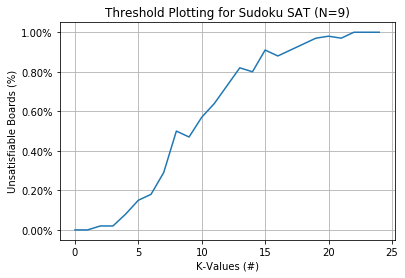

In [11]:
# Plotting Results
fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(PercentFormatter())

ax.set(xlabel='K-Values (#)', ylabel='Unsatisfiable Boards (%)',
       title='Threshold Plotting for Sudoku SAT (N='+str(SUDOKU_DEGREE)+')')

ax.grid()

ax.plot(result)